In [1]:
from neuron import h
import pandas as pd
import numpy as np
from templates.active_model_synapse_input import *

mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_standard.csv'
tstop = 20.  # ms
dt = 0.025  # ms. does not allow change

h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
#h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt

In [2]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

In [3]:
# prior_min = np.array([0,-2000,0,-1,0])
# prior_max = np.array([200,2000,np.pi,1,np.pi])
# nsamples = 1
# loc_param = np.random.uniform(prior_min,prior_max,size=(nsamples,5))
# loc_param

In [4]:
loc_param = [80,350,3.0,0.9,1.27]  # example position
# geo_param = [-1,-1,-1]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])
# biophys = [-1,-1,-1,-1,-1]
sim = Simulation(geo_standard,elec_pos,loc_param,gmax=0.0025,scale=10000.)  # gmax 0.001 -0.012

In [5]:
sec_list = sim.cells[0].all
dend_v = Recorder([sec_list[5](0.1),sec_list[5](0.5),sec_list[5](0.9),sec_list[6](0.5)])

In [6]:
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

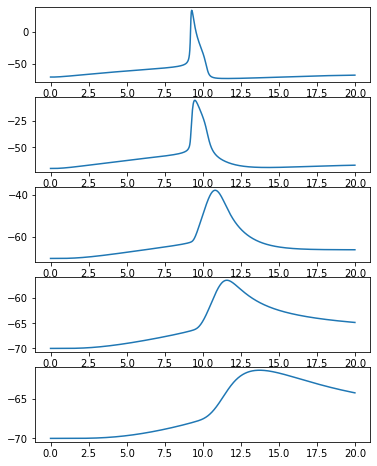

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

v_dend = dend_v.as_numpy()
plt.figure(figsize=(6,8))
plt.subplot(5,1,1)
plt.plot(t,sim.cells[0].v())
for i in range(v_dend.shape[0]):
    plt.subplot(5,1,i+2)
    plt.plot(t,v_dend[i,:])
plt.show()

In [8]:
from scipy import signal

filt_b,filt_a = signal.butter(2,100,'hp',fs=40000) # order 2, 100 Hz, highpass, sampling rate = 40kHz
lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0)

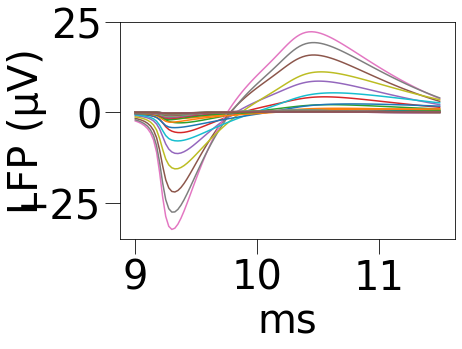

In [9]:
from utils.plot_results import plot_LFP_traces,plot_LFP_heatmap
%matplotlib inline

delay = 9.0
window = [delay,delay+2.51]
idx = (t>=window[0]) & (t<=window[1])  # time index
fig,ax = plot_LFP_traces(t[idx],lfp[idx,:])

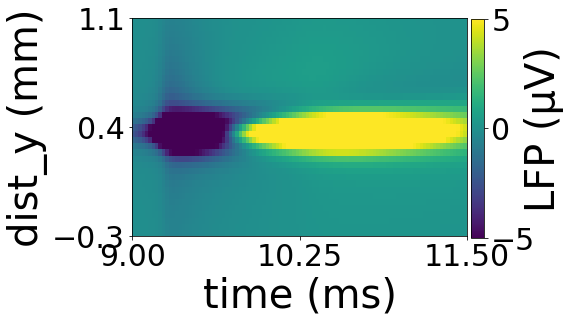

In [10]:
e_idx = slice(40,-20)  # electrodes index
fig,ax = plot_LFP_heatmap(t[idx],pos[e_idx,1],lfp[idx,e_idx],vlim=[-5,5])
# set narrower "vlim" can help see more subtle difference in voltage

Below is an example to find the spike waveform window. First import the functions and obtain the index of first peak/trough of the ground truth trace in the given window.

In [11]:
from utils.spike_window import first_pk_tr, get_spike_window

fst_idx = first_pk_tr(lfp[idx,:])
print("index %d, time %f" % (fst_idx,fst_idx*dt)) # in this case, trough occurs earlier than peak. so the trough index is ruterned

index 12, time 0.300000


Run a simulate with lower input (gmax). In such case, the first peak/trough occurs later.

In [12]:
sim = Simulation(geo_standard,elec_pos,loc_param,gmax=0.002,scale=10000.)
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

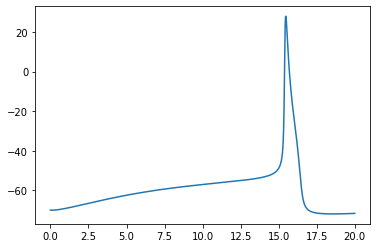

In [13]:
plt.plot(t,sim.cells[0].v())
plt.show()

Use the function "get_spike_window" to get the window of the waveform with 96 time points, using the "fst_idx" point in the given window of the ground truth trace to align with the first peak/trough of this simulated trace. Plot the waveform in the window obtained.

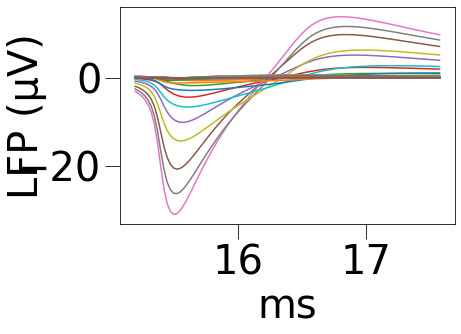

In [14]:
start,end = get_spike_window(lfp,win_size=96,align_at=fst_idx)
fig,ax = plot_LFP_traces(t[start:end],lfp[start:end,:])

In [15]:
help(first_pk_tr)
help(get_spike_window)

Help on function first_pk_tr in module utils.spike_window:

first_pk_tr(lfp)
    Find the time index of first peak/trough in "lfp" (2D array, each column is a channel).

Help on function get_spike_window in module utils.spike_window:

get_spike_window(lfp, win_size, align_at=0)
    Get the window of the spike waveform, where the first peak/trough is aligned at a fixed point in the window.
    lfp: input lfp with spike waveform (2D array, each column is a channel)
    win_size: window size (time samples)
    align_at: time index in the window to align with the first peak/trough in "lfp"
    return (start,end), the time index of the window in "lfp"

